In [1]:
import csv
import numpy as np
import pandas as pd
# First experience with CAPTCHA...
#import requests
#first = requests.get('http://www.pdga.com/players?FirstName=&LastName=&PDGANum=&Status=All&Gender=All&Class=All&MemberType=All&City=&StateProv=All&Country=All&Country_1=All&UpdateDate=&order=Rating_1&sort=desc')
#second = requests.get('https://www.pdga.com/players?FirstName=&LastName=&PDGANum=&Status=All&Gender=All&Class=All&MemberType=All&City=&StateProv=All&Country=All&Country_1=All&UpdateDate=&order=Rating_1&sort=desc&page=1')
#urls = []
#for x in range(1,150):
#    urls.append('http://www.pdga.com/players?FirstName=&LastName=&PDGANum=&Status=All&Gender=All&Class=All&MemberType=All&City=&StateProv=All&Country=All&Country_1=All&UpdateDate=&order=Rating_1&sort=desc&page={}'.format(x))
#df_lst = []
#df_lst.append(pd.read_html(first.text)[0])
#for url in urls:
#    x = requests.get(url)
#    df = pd.read_html(x.text)[0]
#    df_lst.append(df)
#pdga_df = pd.concat(df_lst).reset_index()  
#pdga_df.to_excel('disc_golfers.xlsx')
dg_df = pd.read_excel('disc_golfers.xlsx')
dg_df['State/Prov'] = dg_df['State/Prov'].fillna('INT')
top_earners = pd.read_excel('top_earners.xlsx').drop(columns=['Unnamed: 0']).drop(columns=['index']).drop(columns=['Class']).drop(columns=['Year'])

In [2]:
region_dict = {
    'West' : ['WA', 'OR', 'ID', 'MT', 'CA', 'NV', 'UT', 'CO', 'AK', 'HI'],
    'Southwest' : ['AZ', 'NM', 'TX', 'OK'],
    'Midwest' : ['ND', 'SD', 'NE', 'KS', 'MO', 'IA', 'MN', 'WI', 'MI', 'IL', 'IN', 'OH', 'WY'],
    'Southeast' : ['AR', 'LA', 'MS', 'AL', 'TN', 'KY', 'WV', 'VA', 'NC', 'SC', 'GA', 'FL'],
    'Northeast' : ['PA', 'NY', 'VT', 'NH', 'ME', 'MA', 'RI', 'CT', 'NJ', 'DE', 'MD', 'DC']
}
state_region = {'INT' : 'International'}
for key in region_dict:
    for state in region_dict[key]:
        state_region[state] = key
states = [key for key in state_region]
dg_states = dg_df['State/Prov'].unique()
extra = []
inter = []
for item in dg_states:
    if item not in states:
        extra.append(item)
        inter.append('International')
extra_dict = dict(zip(extra,inter))
state_region.update(extra_dict)
dg_df['Region'] = [state_region[row] for row in dg_df['State/Prov']]

In [3]:
def get_status(status):
    return status.split(' ')[0]
dg_df['Status'] = dg_df['Membership Status'].apply(lambda x: f"{get_status(x)}")
current = dg_df.loc[dg_df['Status'] == 'Current']
current = current.drop(columns=['Membership Status'])

In [8]:
#import requests
#first = requests.get('https://www.pdga.com/players/stats?page=0&Year=2021&player_Class=1&Gender=All&Bracket=All&continent=All&Country=All&StateProv=All&order=Prize&sort=desc')
#urls = []
#for x in range(1,200):
#    urls.append('https://www.pdga.com/players/stats?Year=2021&player_Class=1&Gender=All&Bracket=All&continent=All&Country=All&StateProv=All&order=Prize&sort=desc&page={}'.format(x))
#df_lst1 = []
#df_lst1.append(pd.read_html(first.text)[0])
#for url in urls:
#    x = requests.get(url)
#    df = pd.read_html(x.text)[0]
#    df_lst1.append(df)
#top_earners = pd.concat(df_lst1).reset_index()  
#top_earners.to_excel('top_earners.xlsx')
top_earners['Cash'] = top_earners['Cash'].replace(',', '').replace('$', '').astype(float)
top_earners['State/Province'] = top_earners['State/Province'].fillna('International')
top_earners['PPE'] = (top_earners['Points'] / top_earners['Events']).round(2)
top_earners['CPE'] = (top_earners['Cash'] / top_earners['Events']).round(2)
print(top_earners.dtypes)

Name               object
PDGA #              int64
Rating              int64
Gender             object
Division           object
Country            object
State/Province     object
Events              int64
Points              int64
Cash              float64
PPE               float64
CPE               float64
dtype: object


In [10]:
states_df = pd.read_csv('state_regions.txt')
countries = pd.read_csv('countries.txt')
countries.loc[countries['name'] == 'Czechia', 'name'] = 'Czech Republic'
countries.loc[countries['name'] == 'United Kingdom of Great Britain and Northern Ireland', 'name'] = 'United Kingdom'
countries.loc[countries['name'] == 'Russian Federation', 'name'] = 'Russia'
country_region_dict = dict(zip(countries['name'],countries['region']))
us_states = states_df['State'].tolist()
state_lst = top_earners['State/Province'].unique()
state_region_dict = dict(zip(states_df['State'],states_df['Region']))
outside_us = []
for item in state_lst:
    if item not in us_states:
        outside_us.append(item)

outside_us_dict = {
    'International' : 'International', 
    'Ontario' : 'Canada', 
    'British Columbia' : 'Canada', 
    'Alberta' : 'Canada', 
    'Prince Edward Island' : 'Canada', 
    'Quebec' : 'Canada', 
    'Manitoba' : 'Canada', 
    'Nova Scotia' : 'Canada', 
    'New Brunswick' : 'Canada', 
    'Saskatchewan' : 'Canada', 
    'Victoria' : 'Australia', 
    'Lääne-Virumaa' : 'Finland', 
    'New South Wales' : 'Australia'
}
state_region_dict.update(outside_us_dict)
top_earners['Region'] = [state_region_dict[item] for item in top_earners['State/Province']]
not_us = []
for item in top_earners['Country']:
    if item != 'United States' and item not in not_us:
        not_us.append(item)
for item in not_us:
    top_earners.loc[top_earners['Country'] == item, "Region"] = country_region_dict[item]
#print(top_earners.isna().sum())
top_earners

,Name,PDGA #,Rating,Gender,Division,Country,State/Province,Events,Points,Cash,PPE,CPE,Region
0,P. McBeth,27523,1051,Male,Open,United States,California,23,28010,78903.0,1217.83,3430.57,West
1,R. Wysocki,38008,1053,Male,Open,United States,South Carolina,23,27650,74429.0,1202.17,3236.04,South
2,P. Pierce,29190,988,Female,Open Women,United States,Texas,23,4629,60249.0,201.26,2619.52,South
3,E. McMahon,37817,1053,Male,Open,United States,Colorado,18,21947,58065.0,1219.28,3225.83,West
4,C. Heimburg,45971,1049,Male,Open,United States,Florida,23,25840,54785.0,1123.48,2381.96,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,C. Kurka,112440,960,Male,Open,United States,Delaware,9,445,288.0,49.44,32.00,South
3996,O. Breistein,59468,949,Male,Open,Norway,International,10,1702,288.0,170.20,28.80,Europe
3997,D. Merritt,45960,843,Female,Pro Masters Women 40+,United States,Nevada,2,15,288.0,7.50,144.00,West
3998,K. Tush,90753,934,Male,Pro Masters 40+,United States,North Carolina,7,254,288.0,36.29,41.14,South


['Americas', 'Asia', 'Europe', 'Midwest', 'Northeast', 'Oceania', 'South', 'West']
      Region   Rating  Events   Points        Cash        PPE        CPE
0   Americas   140650     915    99430   146230.29   14054.71   29849.70
1       Asia      908       2      230      309.00     115.00     154.50
2     Europe   407524    3245   778985   390654.84   99804.56   59275.86
3    Midwest   862534    9821  1771107  1610442.00  131014.51  149914.17
4  Northeast   408872    4561   560251   553122.00   45891.04   56486.04
5    Oceania    20028     140    10762    10329.00    1522.47    1776.37
6      South  1108274   13282  1865123  2204823.00  128106.63  201903.74
7       West   881415    8847  1383969  1613606.00  113559.02  165755.48


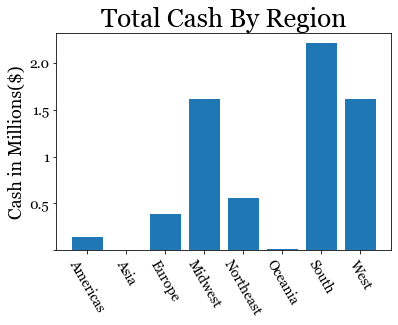

In [7]:
import matplotlib.pyplot as plt
regions = top_earners['Region'].unique().tolist()
regions.sort()
print(regions)
region_totals = top_earners.groupby(['Region']).sum().drop(columns=['PDGA #']).reset_index()
print(region_totals)

title_font = {'family':'georgia', 'size':26}
label_font = {'family':'georgia', 'size':18}
tick_font = {'family':'georgia', 'size':14}

plt.bar(regions,region_totals['Cash'].tolist())
plt.title('Total Cash By Region', fontdict=title_font)
plt.xticks(ticks=range(len(regions)), labels=regions, rotation=300, fontname='georgia', fontsize=14)
plt.yticks(ticks=range(0,2500000,500000),labels=['', '0.5', '1', '1.5', '2.0'], fontname='georgia', fontsize=14)
#plt.xlabel('Region',fontdict=label_font)
plt.ylabel('Cash in Millions($)',fontdict=label_font)
plt.show()

In [12]:
states = top_earners['State/Province'].unique()
state_count_dict = {}
for state in states:
    state_count_dict.update({state : 0})
for state in top_earners['State/Province']:
    state_count_dict[state] += 1
print(state_count_dict)

{'California': 287, 'South Carolina': 44, 'Texas': 302, 'Colorado': 129, 'Florida': 95, 'Michigan': 138, 'Minnesota': 108, 'Virginia': 78, 'Wisconsin': 97, 'Tennessee': 92, 'New York': 80, 'Arkansas': 35, 'Alabama': 64, 'Idaho': 39, 'Missouri': 122, 'Arizona': 47, 'South Dakota': 20, 'Washington': 141, 'North Carolina': 142, 'Oregon': 120, 'West Virginia': 15, 'International': 445, 'Massachusetts': 70, 'Illinois': 91, 'Iowa': 76, 'Ontario': 39, 'Oklahoma': 66, 'Georgia': 74, 'Maryland': 27, 'Maine': 38, 'Kansas': 75, 'Ohio': 87, 'Indiana': 51, 'Nebraska': 22, 'Kentucky': 55, 'Montana': 25, 'Mississippi': 22, 'British Columbia': 24, 'Utah': 34, 'Pennsylvania': 114, 'Louisiana': 33, 'Vermont': 20, 'Rhode Island': 5, 'New Jersey': 37, 'Connecticut': 32, 'Nevada': 34, 'Alaska': 19, 'New Hampshire': 33, 'Delaware': 12, 'New Mexico': 33, 'Alberta': 41, 'Prince Edward Island': 4, 'Quebec': 13, 'Manitoba': 5, 'North Dakota': 12, 'Wyoming': 7, 'Nova Scotia': 7, 'New Brunswick': 7, 'Saskatchewan

AttributeError: 'numpy.ndarray' object has no attribute 'count'